# **Sentiment Analysis of Public Opinion on the IKN Project**

This project focuses on the sentiment analysis of public opinion regarding the IKN (Ibu Kota Nusantara), the new capital of Indonesia.

The project leverages NLP techniques, specifically sentiment analysis, to categorize YouTube comments into three sentiments: positive, negative, or neutral.

The analysis involves comparing the performance of three different models: Logistic Regression (LR), Long Short-Term Memory (LSTM), and Gated Recurrent Units (GRU). The goal is to evaluate and compare the effectiveness of these models in accurately predicting the sentiment of public opinions expressed online, especially in relation to the IKN project.

## Import Library

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import csv
import requests
import emoji
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load Dataset

In [2]:
data = pd.read_csv("comments_ikn.csv")

In [3]:
data

,author,updated_at,like_count,text,video_id,public
0,@beluwuga,2024-10-30T08:15:26Z,0,Gila baru 2 tahun sudah jadi segitu… I can’t w...,MSmv4ImbZjk,True
1,@nurkhusaini4297,2024-10-30T03:22:05Z,0,Yg namanya lagi di bangun,MSmv4ImbZjk,True
2,@Handcraftme,2024-10-08T15:48:46Z,0,Aduh paru-paru Dunia yang perlahan tergerus🥲\n...,MSmv4ImbZjk,True
3,@YogaErlangga-u1r,2024-10-06T10:42:24Z,0,buzzer😂,MSmv4ImbZjk,True
4,@denisyam7069,2024-10-02T05:36:47Z,0,Wajar aja,MSmv4ImbZjk,True
...,...,...,...,...,...,...
30939,@widikrapyak5444,2024-06-13T11:11:27Z,57,Tanpa amdal,mU6BqSzv1cE,True
30940,@harmannyutsa3969,2024-06-13T11:11:10Z,30,Aduuuh kok sedih dengarkan ini ...... Kenapa k...,mU6BqSzv1cE,True
30941,@Ranu-y8y,2024-06-13T11:08:02Z,15,Maunya seperti Roro Jonggrang.,mU6BqSzv1cE,True
30942,@andaruba,2024-06-13T11:07:14Z,8,Menyimak.,mU6BqSzv1cE,True


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30944 entries, 0 to 30943
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   author      30944 non-null  object
 1   updated_at  30944 non-null  object
 2   like_count  30944 non-null  int64 
 3   text        30943 non-null  object
 4   video_id    30944 non-null  object
 5   public      30944 non-null  bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 1.2+ MB


In [5]:
# Took only the text column
clean_data = data[['text']]

In [6]:
clean_data.head()

,text
0,Gila baru 2 tahun sudah jadi segitu… I can’t w...
1,Yg namanya lagi di bangun
2,Aduh paru-paru Dunia yang perlahan tergerus🥲\n...
3,buzzer😂
4,Wajar aja


In [7]:
clean_data.tail()

,text
30939,Tanpa amdal
30940,Aduuuh kok sedih dengarkan ini ...... Kenapa k...
30941,Maunya seperti Roro Jonggrang.
30942,Menyimak.
30943,Beginilah kalau pemimpin bodoh dikelilingi org...


In [8]:
# Check for missing values
clean_data.isnull().sum()

text    1
dtype: int64

In [9]:
# Drop missing values
clean_data.dropna(inplace=True)

In [10]:
# Check for duplicates
clean_data.duplicated().sum()

338

In [11]:
# Drop duplicates
clean_data = clean_data.drop_duplicates()

In [12]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30605 entries, 0 to 30943
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    30605 non-null  object
dtypes: object(1)
memory usage: 478.2+ KB


In [13]:
clean_data.shape

(30605, 1)

## Data Preprocessing

Here are the functions used for cleaning and processing text:

1. `removeEmoji(text)`: This function is used to remove emojis from the text.

2. `normalizeRepeatedCharacters(text)`: This function handles excessive repetition of characters. It removes any character repeated more than twice.

3. `cleaningText(text)`: This function cleans the text with several steps, such as removing mentions, hashtags, retweets (RT), links, numbers, and punctuation marks. It also replaces newline characters with spaces and removes extra spaces at the beginning and end of the text.

4. `casefoldingText(text)`: This function converts all characters in the text to lowercase, making the text more uniform.

5. `tokenizingText(text)`: This function is used to break the text into a list of words or tokens, useful for parsing the text into its basic components.

6. `filteringText(text)`: This function removes stopwords (common words that don't carry significant meaning, like "and", "the", etc.) from the text.

7. `stemmingText(text)`: This function applies stemming to the text, reducing words to their root form. It uses the Sastrawi library for stemming in the Indonesian language.

8. `toSentence(list_words)`: This function combines a list of words back into a single sentence.

In [14]:
def removeEmoji(text):
    return emoji.replace_emoji(text, replace="")

def normalizeRepeatedCharacters(text):
    return re.sub(r'(.)\1{2,}', r'\1', text)

def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')
    return text

def casefoldingText(text):
    text = text.lower()
    return text

def tokenizingText(text):
    text = word_tokenize(text)
    return text

def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","lho","kah","woi","woii","woy","nih","dong","deh","wkwk","haha"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [15]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"}

def fix_slangwords(text):
    words = text.split()
    fixed_words = []
    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)
    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [16]:
clean_data

,text
0,Gila baru 2 tahun sudah jadi segitu… I can’t w...
1,Yg namanya lagi di bangun
2,Aduh paru-paru Dunia yang perlahan tergerus🥲\n...
3,buzzer😂
4,Wajar aja
...,...
30939,Tanpa amdal
30940,Aduuuh kok sedih dengarkan ini ...... Kenapa k...
30941,Maunya seperti Roro Jonggrang.
30942,Menyimak.


In [17]:
# Clean the text and save it in the 'text_clean' column
clean_data['text_clean'] = clean_data['text'].apply(cleaningText)
clean_data['text_clean'] = clean_data['text_clean'].apply(removeEmoji)
clean_data['text_clean'] = clean_data['text_clean'].apply(normalizeRepeatedCharacters)

# Change the letters in the text to lowercase and save it in the 'text_casefoldingText' column
clean_data['text_casefoldingText'] = clean_data['text_clean'].apply(casefoldingText)

# Change slang words to standard words and save it in the 'text_slangwords' column
clean_data['text_slangwords'] = clean_data['text_casefoldingText'].apply(fix_slangwords)

# Split the text into tokens (words) and save it in the 'text_tokenizingText' column
clean_data['text_tokenizingText'] = clean_data['text_slangwords'].apply(tokenizingText)

# Remove stop words (common words) and save it in the 'text_stopword' column
clean_data['text_stopword'] = clean_data['text_tokenizingText'].apply(filteringText)

# Combine tokens into sentences and save them in the 'text_final' column
clean_data['text_final'] = clean_data['text_stopword'].apply(toSentence)

In [18]:
clean_data

,text,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_final
0,Gila baru 2 tahun sudah jadi segitu… I can’t w...,Gila baru tahun sudah jadi segitu I cant wait,gila baru tahun sudah jadi segitu i cant wait,gila baru tahun sudah jadi segitu i cant wait,"[gila, baru, tahun, sudah, jadi, segitu, i, ca...","[gila, segitu, cant, wait]",gila segitu cant wait
1,Yg namanya lagi di bangun,Yg namanya lagi di bangun,yg namanya lagi di bangun,yang namanya lagi di bangun,"[yang, namanya, lagi, di, bangun]","[namanya, bangun]",namanya bangun
2,Aduh paru-paru Dunia yang perlahan tergerus🥲\n...,Aduh paruparu Dunia yang perlahan tergerus ter...,aduh paruparu dunia yang perlahan tergerus ter...,aduh paruparu dunia yang perlahan tergerus ter...,"[aduh, paruparu, dunia, yang, perlahan, terger...","[aduh, paruparu, dunia, perlahan, tergerus, te...",aduh paruparu dunia perlahan tergerus terkecua...
3,buzzer😂,buzzer,buzzer,buzzer,[buzzer],[buzzer],buzzer
4,Wajar aja,Wajar aja,wajar aja,wajar saja,"[wajar, saja]",[wajar],wajar
...,...,...,...,...,...,...,...
30939,Tanpa amdal,Tanpa amdal,tanpa amdal,tanpa amdal,"[tanpa, amdal]",[amdal],amdal
30940,Aduuuh kok sedih dengarkan ini ...... Kenapa k...,Aduh kok sedih dengarkan ini Kenapa kok grusa...,aduh kok sedih dengarkan ini kenapa kok grusa...,aduh kok sedih dengarkan ini kenapa kok grusa ...,"[aduh, kok, sedih, dengarkan, ini, kenapa, kok...","[aduh, sedih, dengarkan, grusa, grusu, kota, h...",aduh sedih dengarkan grusa grusu kota hantu
30941,Maunya seperti Roro Jonggrang.,Maunya seperti Roro Jonggrang,maunya seperti roro jonggrang,maunya seperti roro jonggrang,"[maunya, seperti, roro, jonggrang]","[maunya, roro, jonggrang]",maunya roro jonggrang
30942,Menyimak.,Menyimak,menyimak,menyimak,[menyimak],[menyimak],menyimak


## Labeling Data

In [19]:
# Read positive lexicon data from GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

# Send an HTTP request to get the CSV file from GitHub
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

# Read negative lexicon data from GitHub
lexicon_negative = dict()

# Send an HTTP request to get the CSV file from GitHub
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")

In [20]:
# Function to determine the sentiment polarity of a text
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # If the word is in the positive lexicon, add the score to the sentiment score
    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            # If the word is in the negative lexicon, subtract the score from the sentiment score

    polarity=''

    if score > 0.5:  # Positive threshold
        polarity = 'positive'
    elif score < -0.5:  # Negative threshold
        polarity = 'negative'
    else:  # Neutral threshold
        polarity = 'neutral'

    return score, polarity

In [21]:
results = clean_data['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_data['polarity_score'] = results[0]
clean_data['polarity'] = results[1]
print(clean_data['polarity'].value_counts())

polarity
negative    14768
positive     8975
neutral      6862
Name: count, dtype: int64


## Data Visualization

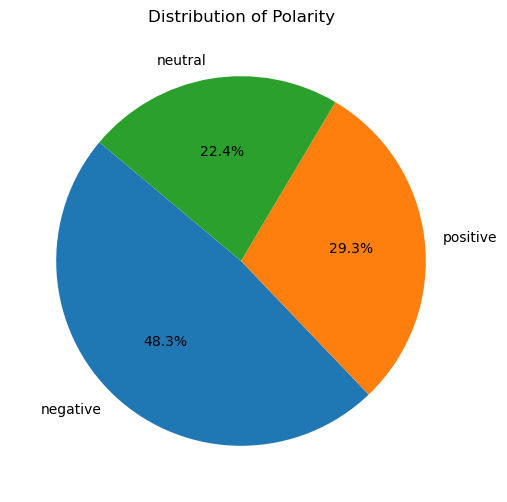

In [22]:
# Visualize the distribution of polarity
polarity_counts = clean_data['polarity'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(polarity_counts, labels=polarity_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Polarity')
plt.show()

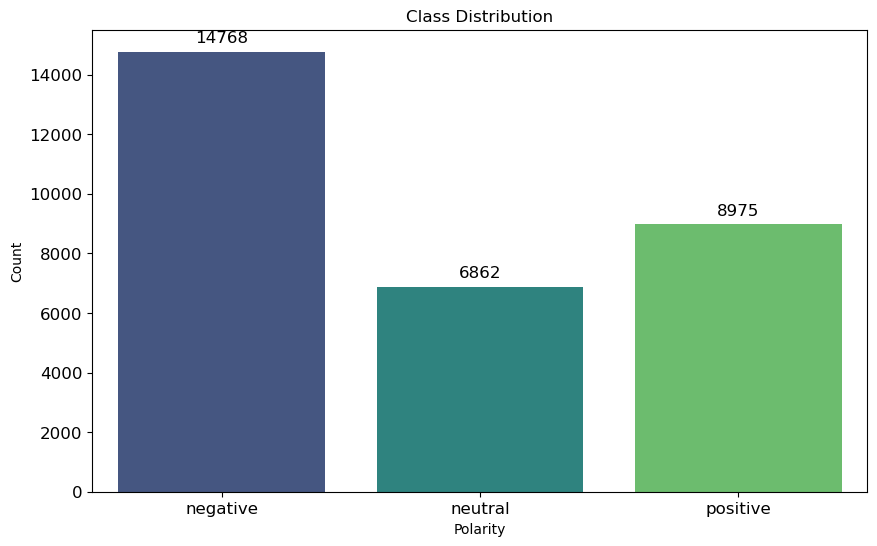

In [23]:
# Visualize the distribution of polarity
plt.figure(figsize=(10, 6))

class_dist_plot = sns.countplot(x='polarity', data=clean_data, hue='polarity', palette='viridis',legend=False)
plt.title('Class Distribution')

for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              xytext=(0, 10),
                              textcoords='offset points',
                              fontsize=12)

plt.xlabel('Polarity')
plt.ylabel('Count')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

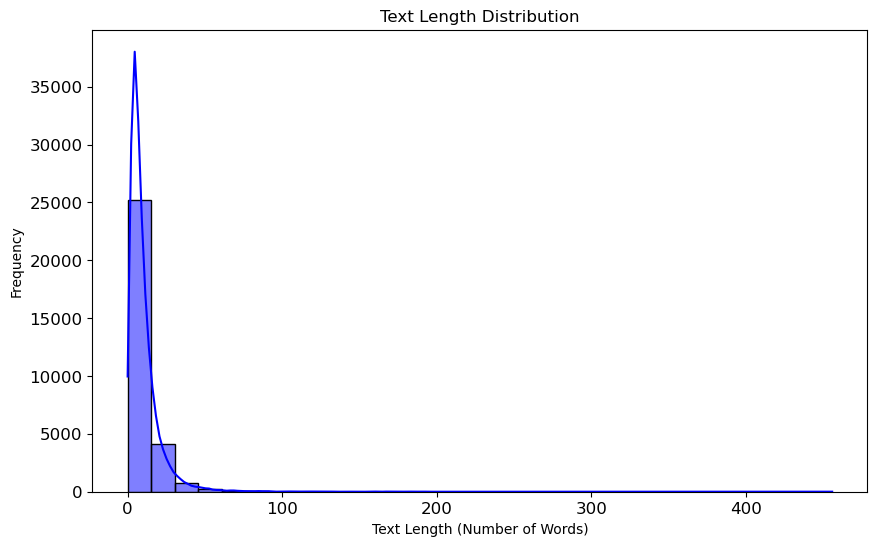

In [24]:
# Visualize the distribution of text length
data['text_length'] = clean_data['text_final'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

plt.figure(figsize=(10, 6))

sns.histplot(data['text_length'], bins=30, kde=True, color='blue')
plt.title('Text Length Distribution')
plt.xlabel('Text Length (Number of Words)')
plt.ylabel('Frequency')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

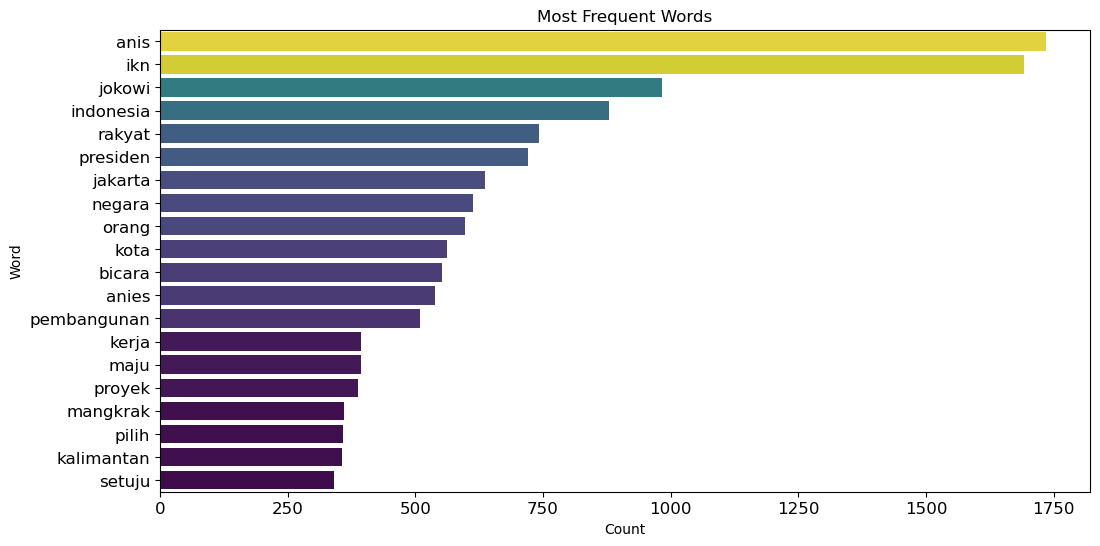

In [25]:
# Show the words that appear most frequently
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(clean_data['text_final'].dropna())

tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

word_counts = tfidf_df.sum().reset_index()
word_counts.columns = ['word', 'count']

most_frequent = word_counts.sort_values('count', ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='word', data=most_frequent, hue='count', palette='viridis', legend=False)
plt.title('Most Frequent Words')
plt.xlabel('Count')
plt.ylabel('Word')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

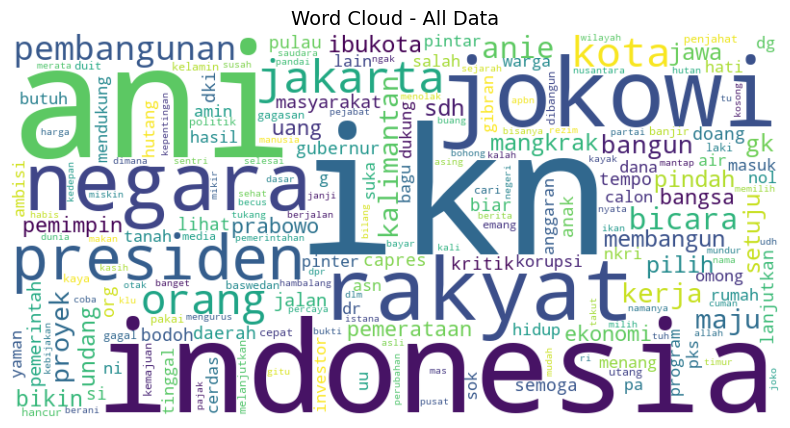

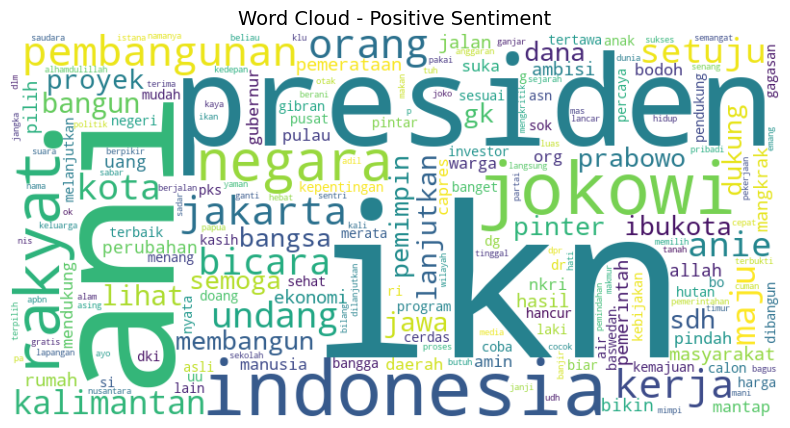

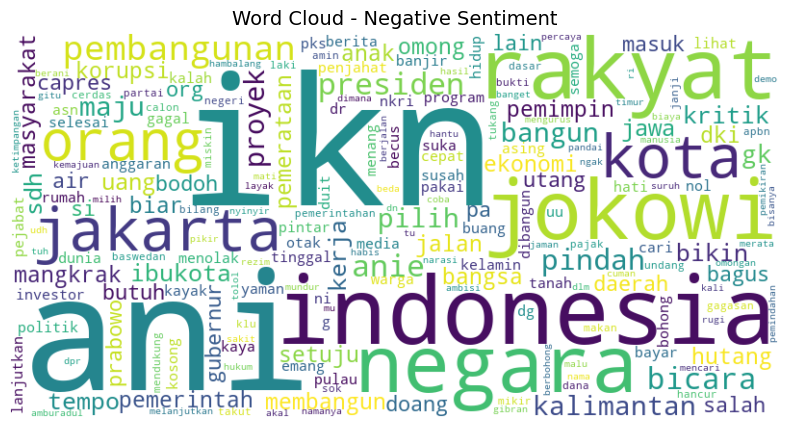

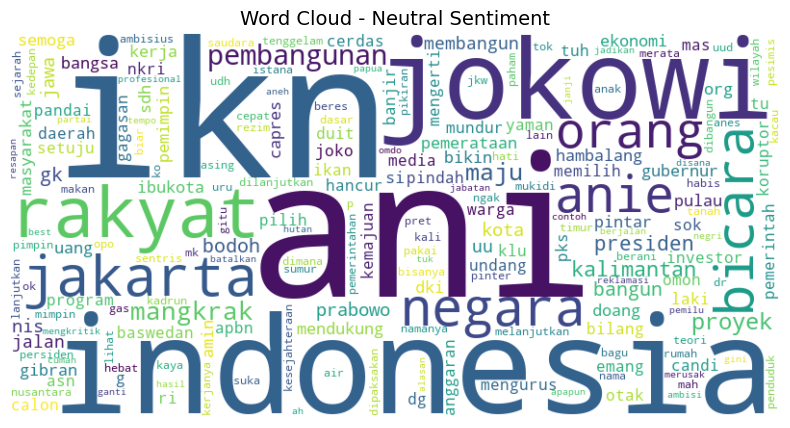

In [26]:
# Function to generate a word cloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        collocations=False
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=14)
    plt.show()

# Word Cloud for all data
all_text = ' '.join(clean_data['text_final'].dropna())
generate_wordcloud(all_text, 'Word Cloud - All Data')

# Word Cloud for positive polarity
positive_text = ' '.join(clean_data[clean_data['polarity'] == 'positive']['text_final'].dropna())
generate_wordcloud(positive_text, 'Word Cloud - Positive Sentiment')

# Word Cloud for negative polarity
negative_text = ' '.join(clean_data[clean_data['polarity'] == 'negative']['text_final'].dropna())
generate_wordcloud(negative_text, 'Word Cloud - Negative Sentiment')

# Word Cloud for neutral polarity
neutral_text = ' '.join(clean_data[clean_data['polarity'] == 'neutral']['text_final'].dropna())
generate_wordcloud(neutral_text, 'Word Cloud - Neutral Sentiment')

## Modeling

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [28]:
clean_data.head(2)

,text,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_final,polarity_score,polarity
0,Gila baru 2 tahun sudah jadi segitu… I can’t w...,Gila baru tahun sudah jadi segitu I cant wait,gila baru tahun sudah jadi segitu i cant wait,gila baru tahun sudah jadi segitu i cant wait,"[gila, baru, tahun, sudah, jadi, segitu, i, ca...","[gila, segitu, cant, wait]",gila segitu cant wait,-5,negative
1,Yg namanya lagi di bangun,Yg namanya lagi di bangun,yg namanya lagi di bangun,yang namanya lagi di bangun,"[yang, namanya, lagi, di, bangun]","[namanya, bangun]",namanya bangun,0,neutral


### Model 1 - Logistic Regression

In [29]:
# Split the data into features (text_final) and labels (polarity)
X = clean_data['text_final']
y = clean_data['polarity']

In [30]:
# Feature extraction using TF-IDF
tfidf_lr = TfidfVectorizer(max_features=3000, min_df=5, max_df=0.8 )
X_tfidf_lr = tfidf_lr.fit_transform(X)

features_df = pd.DataFrame(X_tfidf_lr.toarray(), columns=tfidf_lr.get_feature_names_out())

In [31]:
# Split the data into training and testing sets
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_tfidf_lr, y, test_size=0.3, random_state=42)

In [32]:
from sklearn.linear_model import LogisticRegression

# Create a Logistic Regression model
logistic_regression = LogisticRegression(max_iter=200)

# Train the model
logistic_regression.fit(X_train_lr.toarray(), y_train_lr)

# Predict the polarity of the training and testing data
y_pred_train_lr = logistic_regression.predict(X_train_lr.toarray())
y_pred_test_lr = logistic_regression.predict(X_test_lr.toarray())

# Evaluation of the Logistic Regression model on the training data
accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train_lr)

# Evaluation of the Logistic Regression model on the testing data
accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test_lr)

# Print the accuracy
print('Train Accuracy:', accuracy_train_lr)
print('Test Accuracy:', accuracy_test_lr)

Train Accuracy: 0.8958595901601083
Test Accuracy: 0.8392507079067741


Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.90      0.88      4413
     neutral       0.78      0.78      0.78      2068
    positive       0.87      0.78      0.82      2701

    accuracy                           0.84      9182
   macro avg       0.83      0.82      0.83      9182
weighted avg       0.84      0.84      0.84      9182



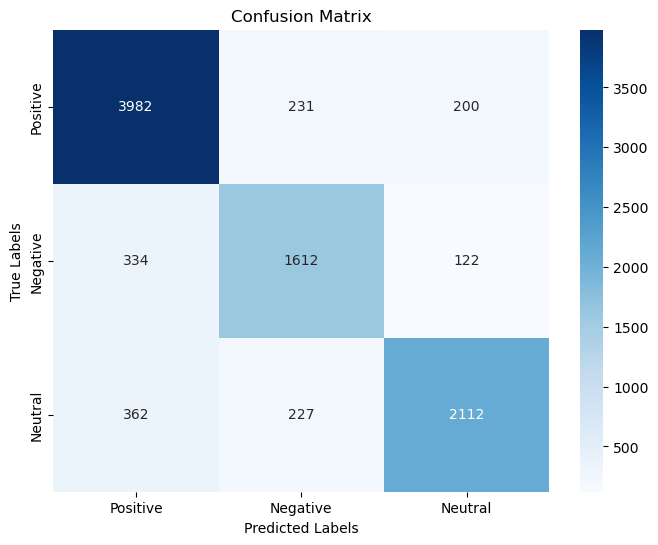

In [33]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test_lr, y_pred_test_lr))

# Confusion Matrix
conf_matrix_test = confusion_matrix(y_test_lr, y_pred_test_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative', 'Neutral'], yticklabels=['Positive', 'Negative', 'Neutral'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Model 2 - LSTM

In [34]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [35]:
# Split the data into features (text_final) and labels (polarity)
texts = clean_data['text_final']
labels = clean_data['polarity']

# Map the labels to numerical values
label_mapping = {'positive': 0, 'negative': 1, 'neutral': 2}
labels = labels.map(label_mapping)

In [36]:
# Tokenization of text and padding to ensure uniform input length
max_length = 100 

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(texts)
X_seq = tokenizer.texts_to_sequences(texts)
X_pad = pad_sequences(X_seq, maxlen=max_length)

# One-hot encoding label
y = to_categorical(labels, num_classes=3)

In [37]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)

In [38]:
# Build the LSTM model
lstm_model = Sequential([
            Embedding(input_dim=5000, output_dim=128),
            LSTM(128, return_sequences=True),
            Dropout(0.4),
            LSTM(64, return_sequences=True),
            Dropout(0.4),
            LSTM(32),
            Dense(64, activation='relu'),
            Dropout(0.4),
            Dense(3, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

# Train the model
history = lstm_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 85s 123ms/step - accuracy: 0.5577 - loss: 0.9306 - val_accuracy: 0.8340 - val_loss: 0.4609 - learning_rate: 0.0010
Epoch 2/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 75s 123ms/step - accuracy: 0.8799 - loss: 0.3632 - val_accuracy: 0.8711 - val_loss: 0.3776 - learning_rate: 0.0010
Epoch 3/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 75s 122ms/step - accuracy: 0.9255 - loss: 0.2411 - val_accuracy: 0.8709 - val_loss: 0.4005 - learning_rate: 0.0010
Epoch 4/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 78s 128ms/step - accuracy: 0.9335 - loss: 0.2084 - val_accuracy: 0.8767 - val_loss: 0.4072 - learning_rate: 0.0010
Epoch 5/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 79s 129ms/step - accuracy: 0.9448 - loss: 0.1745 - val_accuracy: 0.8642 - val_loss: 0.4749 - learning_rate: 0.0010
Epoch 6/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 76s 124ms/step - accuracy: 0.9513 - loss: 0.1476 - val_accuracy: 0.8652 - val_loss: 0.4848 - learning_rate: 2.0000e-04
Epoch 7/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 79s 129ms/step - accuracy:

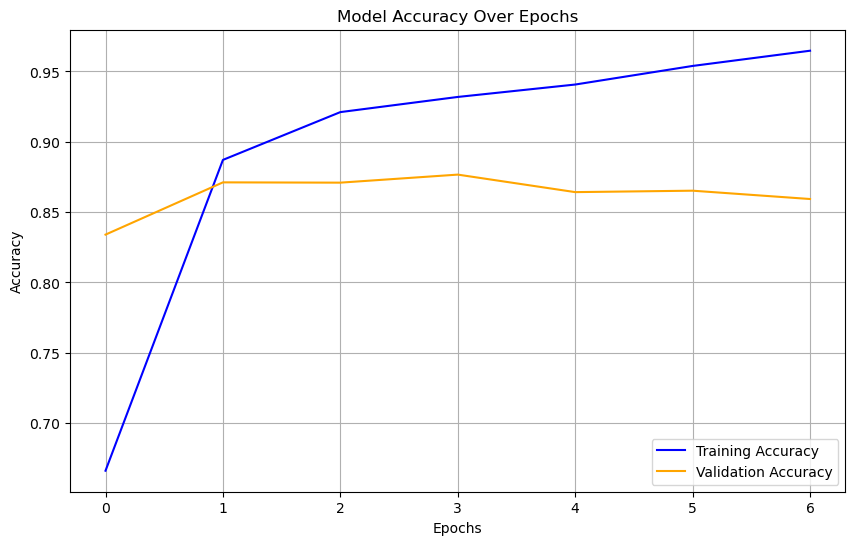

In [40]:
# Plot training and validation accuracy
def plot_accuracy(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(visible=True)
    plt.show()

plot_accuracy(history)

In [41]:
# Evaluate the model on the training data
train_loss_lstm, train_accuracy_lstm = lstm_model.evaluate(X_train, y_train)
print(f"Train Accuracy: {train_accuracy_lstm * 100:.2f}%")

# Evaluate the model on the test data
test_loss_lstm, test_accuracy_lstm = lstm_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy_lstm * 100:.2f}%")

766/766 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.9310 - loss: 0.2205
Train Accuracy: 91.84%
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.8731 - loss: 0.3787
Test Accuracy: 87.86%


192/192 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1792
           1       0.90      0.91      0.91      2940
           2       0.89      0.80      0.84      1389

    accuracy                           0.88      6121
   macro avg       0.88      0.87      0.87      6121
weighted avg       0.88      0.88      0.88      6121



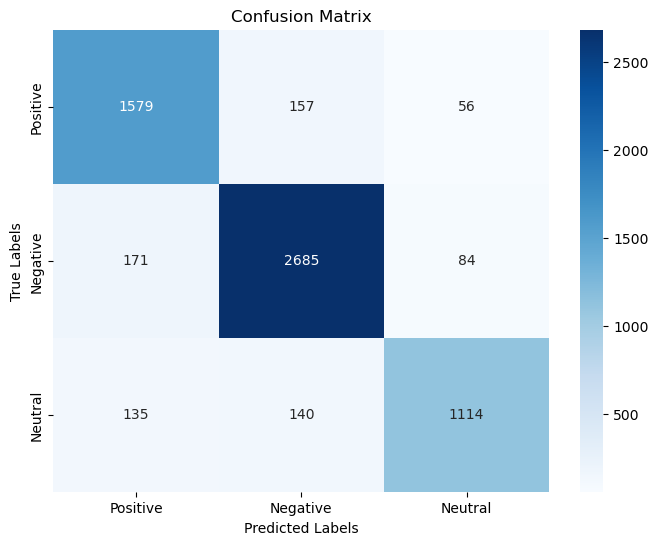

In [42]:
# Make predictions on test data
y_pred_lstm = lstm_model.predict(X_test)
y_pred_lstm = np.argmax(y_pred_lstm, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_test.argmax(axis=1), y_pred_lstm))

# Confusion Matrix
conf_matrix_lstm = confusion_matrix(y_test.argmax(axis=1), y_pred_lstm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative', 'Neutral'], yticklabels=['Positive', 'Negative', 'Neutral'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Model 3 - GRU

In [43]:
from keras.models import Sequential
from keras.layers import GRU, Embedding, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [44]:
# Split the data into features (text_final) and labels (polarity)
X = clean_data['text_final']
y = clean_data['polarity']

In [45]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
max_length = 100
X_pad = pad_sequences(X_seq, maxlen=max_length)

# Convert string labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# One-hot encode the labels
y_encoded = to_categorical(y_encoded, num_classes=3)

In [46]:
# Split data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_encoded, test_size=0.2, random_state=42)

In [47]:
# Build the GRU model
gru_model = Sequential([
    Embedding(input_dim=5000, output_dim=128),
    GRU(128, return_sequences=True),
    Dropout(0.3),
    GRU(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

# Compile the model
initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)
gru_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True, 
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=3, 
    verbose=1, 
    min_lr=1e-6
)

# Train the model
history = gru_model.fit(
    X_train, 
    y_train, 
    epochs=20,
    batch_size=32, 
    validation_split=0.2, 
    verbose=1, 
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20


613/613 ━━━━━━━━━━━━━━━━━━━━ 70s 101ms/step - accuracy: 0.6490 - loss: 0.7892 - val_accuracy: 0.8503 - val_loss: 0.4162 - learning_rate: 0.0010
Epoch 2/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 59s 96ms/step - accuracy: 0.8953 - loss: 0.3214 - val_accuracy: 0.8664 - val_loss: 0.4166 - learning_rate: 0.0010
Epoch 3/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 59s 96ms/step - accuracy: 0.9240 - loss: 0.2336 - val_accuracy: 0.8711 - val_loss: 0.4046 - learning_rate: 0.0010
Epoch 4/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 85s 100ms/step - accuracy: 0.9384 - loss: 0.1908 - val_accuracy: 0.8677 - val_loss: 0.4604 - learning_rate: 0.0010
Epoch 5/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 58s 95ms/step - accuracy: 0.9454 - loss: 0.1634 - val_accuracy: 0.8687 - val_loss: 0.4403 - learning_rate: 0.0010
Epoch 6/20
612/613 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9524 - loss: 0.1436
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
613/613 ━━━━━━━━━━━━━━━━━━━━ 55s 90ms/step - accuracy: 0.9524 - loss: 0.1437

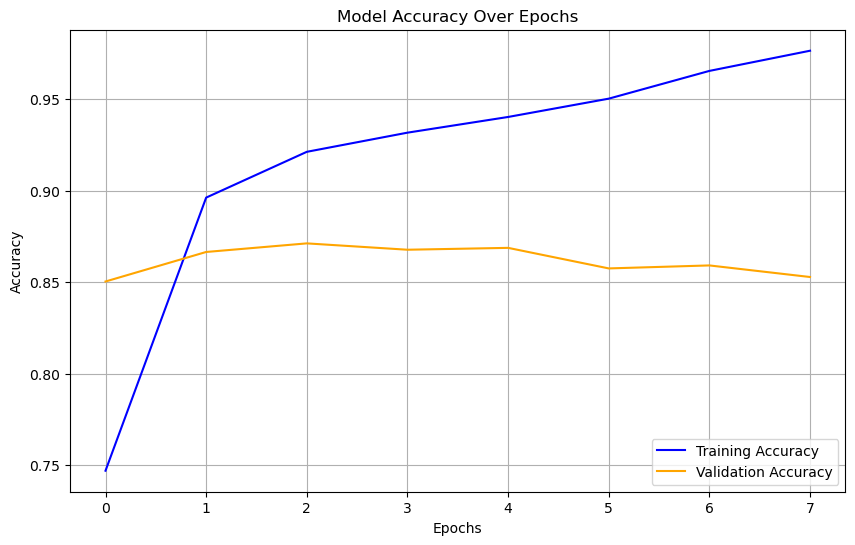

In [49]:
# Plot training and validation accuracy
def plot_accuracy(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(visible=True)
    plt.show()

plot_accuracy(history)

In [50]:
# Evaluate the model on the training data
train_loss_gru, train_accuracy_gru = gru_model.evaluate(X_train, y_train)
print(f"Train Accuracy: {train_accuracy_gru * 100:.2f}%")

# Evaluate the model on the test data
test_loss_gru, test_accuracy_gru = gru_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy_gru * 100:.2f}%")

766/766 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.9411 - loss: 0.1730
Train Accuracy: 92.69%
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8741 - loss: 0.4119
Test Accuracy: 87.98%


192/192 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.90      2940
           1       0.91      0.78      0.84      1389
           2       0.87      0.86      0.86      1792

    accuracy                           0.88      6121
   macro avg       0.88      0.86      0.87      6121
weighted avg       0.88      0.88      0.88      6121



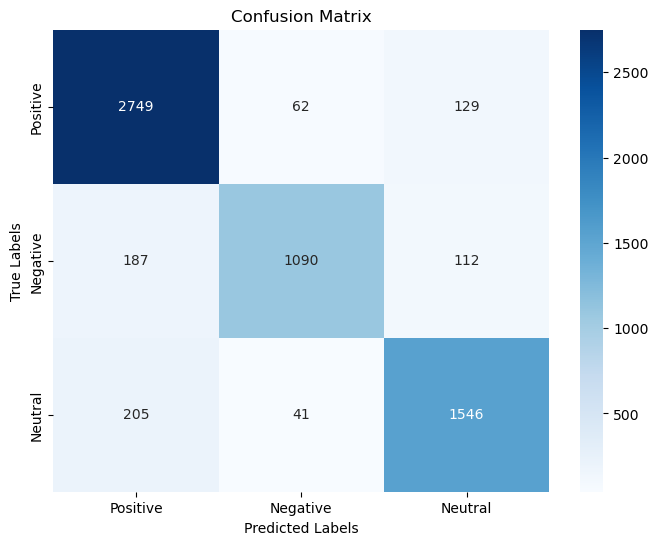

In [51]:
# Make predictions on the test set
y_pred_gru = gru_model.predict(X_test)
y_pred_gru = np.argmax(y_pred_gru, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_pred_gru))

# Confusion Matrix
conf_matrix_gru = confusion_matrix(np.argmax(y_test, axis=1), y_pred_gru)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gru, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative', 'Neutral'], yticklabels=['Positive', 'Negative', 'Neutral'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Final Evaluation

In [52]:
# Define accuracy results for each model
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'LSTM', 'GRU'],
    'Accuracy Train': [accuracy_train_lr, train_accuracy_lstm, train_accuracy_gru],
    'Accuracy Test': [accuracy_test_lr, test_accuracy_lstm, test_accuracy_gru]
})

print(results_df)

                 Model  Accuracy Train  Accuracy Test
0  Logistic Regression        0.895860       0.839251
1                 LSTM        0.918355       0.878615
2                  GRU        0.926850       0.879758


In this Sentiment Analysis case, both the LSTM and GRU models achieved the same accuracy of 87%. Given their similar accuracy, either model could be chosen for predicting sentiment in new sentences.

In [60]:
# Input a new sentence from the user
new_sentence = input("Enter a new sentence: ")

# Preprocess the new sentence
new_sentence_cleaned = cleaningText(new_sentence)
new_sentence_casefolded = casefoldingText(new_sentence_cleaned)
new_sentence_slangfixed = fix_slangwords(new_sentence_casefolded)
new_sentence_tokenized = tokenizingText(new_sentence_slangfixed)
new_sentence_filtered = filteringText(new_sentence_tokenized)
new_sentence_final = toSentence(new_sentence_filtered)

# Tokenize and pad the new sentence
new_sentence_sequence = tokenizer.texts_to_sequences([new_sentence_final])
new_sentence_padded = pad_sequences(new_sentence_sequence, maxlen=max_length)

# Use the LSTM model to predict the sentiment
predicted_sentiment = gru_model.predict(new_sentence_padded)

# Decode the prediction
sentiment_label = np.argmax(predicted_sentiment, axis=1)

# Map sentiment labels to readable text
label_map = {0: "NEGATIVE", 1: "NEUTRAL", 2: "POSITIVE"}
predicted_label = label_map[sentiment_label[0]]

# Display the input text and the predicted sentiment
print("\nInput Text: ", new_sentence)
print("Predicted Sentiment: ", predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

Input Text:  Sukses selalu IKN wujud nyata karya anak bangsa
Predicted Sentiment:  POSITIVE


## Conclusion

In this project, sentiment analysis was carried out through several stages, including data scraping, data preprocessing, data labeling, feature extraction, and machine learning modeling. 

Data scraping was done by collecting comments from 6 YouTube videos about the IKN (Ibu Kota Nusantara). The total dataset consists of approximately 30.000 entries. Three model training schemes were tested as follows:

- **Model 1 =** Logistic Regression (LR), Feature Extraction: TF-IDF, Data Split: 70:30
- **Model 2 =** Long Short-Term Memory (LSTM), Data Split: 80:20
- **Model 3 =** Gated Recurrent Unit (GRU), Data Split: 80:20

The results show that Model 1 (Logistic Regression) achieved a test accuracy of 83%. Models 2 (LSTM) and 3 (GRU) both achieved an accuracy of 87%, outperforming Logistic Regression. However, further optimization of the LSTM and GRU models could potentially improve their performance.